In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import MobileNet_V2_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import Dataset, DataLoader
# https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

/home/alf/anul4/depth/venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class DepthwiseUpSampleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_depth = nn.Conv2d(in_channels = in_channels, out_channels=in_channels, kernel_size=(5,5), padding=2, groups=in_channels)
        self.bn1 = nn.BatchNorm2d(num_features=in_channels) 
        self.relu6 = nn.ReLU6(inplace=True)
        self.conv_pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x  = self.relu6(self.bn1(self.conv_depth(x)))
        x = self.relu(self.bn2(self.conv_pointwise(x)))
        return F.interpolate(x, scale_factor=2, mode='nearest')
        
class FastDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobile_v2_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.dec1 = DepthwiseUpSampleConvolution(320, 96)
        self.dec2 = DepthwiseUpSampleConvolution(96, 32)
        self.dec3 = DepthwiseUpSampleConvolution(32, 24)
        self.dec4 = DepthwiseUpSampleConvolution(24, 16)
        self.dec5 = DepthwiseUpSampleConvolution(16, 32)
        self.final_conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.mobile_v2_encoder.features[0](x)
        x = self.mobile_v2_encoder.features[1](x)
        layer1 = x
        x = self.mobile_v2_encoder.features[2](x)
        x = self.mobile_v2_encoder.features[3](x)
        layer2 = x
        x = self.mobile_v2_encoder.features[4](x)
        x = self.mobile_v2_encoder.features[5](x)
        layer3 = x
        for i in range(6, 18):
            x = self.mobile_v2_encoder.features[i](x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = x + layer3
        x = self.dec3(x)
        x = x + layer2
        x = self.dec4(x)
        x = x + layer1
        x = self.dec5(x)
        return self.final_conv(x)

In [3]:
import csv
import numpy as np

TRAIN_DATA = "./nyu_data/data/nyu2_train.csv"
TEST_DATA = "./nyu_data/data/nyu2_test.csv"
MAX_TRAINING_VALUE = 255
MAX_VALIDATION_VALUE = 10000 # 10 meters expressed in milimiters

class DepthImageDataset(Dataset):
    def __init__(self, csv_file_name, train=True, transform=None):
        self.transform = transform
        self.files_paths = []
        self.label_paths = []
        self.train = train
        with open(csv_file_name, mode ='r') as file:
            csvFile = csv.reader(file)
            for lines in csvFile:
                self.files_paths.append("./nyu_data/" + lines[0])
                self.label_paths.append("./nyu_data/" + lines[1])

    def __len__(self):
        return len(self.files_paths)
    
    def get_my_item(self, idx):
        return self.__getitem__(idx)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.files_paths[idx], flags=cv2.IMREAD_COLOR)
        depth_img = cv2.imread(self.label_paths[idx], flags=cv2.IMREAD_UNCHANGED)
        if (depth_img.dtype == np.uint8):
            depth_img = depth_img / MAX_TRAINING_VALUE
        else:
            depth_img = depth_img / MAX_VALIDATION_VALUE
        if (self.transform == None):
            return img, depth_img
        transformed = self.transform(image=img, mask=depth_img)
        return transformed['image'], transformed['mask'].unsqueeze(dim=0)

In [4]:
import os
PATH_MODEL = "./trained_fast_depth.pth"
RELATIVE_ERROR = 0.15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_cuda_model(load_data_path: bool):
    model = FastDepth()
    if load_data_path and os.path.isfile(PATH_MODEL):
        print("A citit dintr-ul fisier")
        model.load_state_dict(torch.load(PATH_MODEL, weights_only=True))
    model = model.to(DEVICE)
    print("Device-ul folosite este", DEVICE)
    print("Modelul a fost creat cu succes")
    return model

def get_cpu_model(load_data_path: bool):
    model = FastDepth()
    if load_data_path and os.path.isfile(PATH_MODEL):
        model.load_state_dict(torch.load(PATH_MODEL, weights_only=True))
    print("Device-ul folosite este cpu")
    return model

class EarlyStopping:
    def __init__(self, model : FastDepth, patience, path):
        self.path = path
        self.patience = patience
        self.model = model
        self.current_patience = patience
        self.current_loss = float('inf')

    def should_continue(self, loss):
        if (loss < self.current_loss):
            self.current_loss = loss
            self.current_patience = self.patience
            torch.save(self.model.state_dict(), PATH_MODEL)
            return True
        self.current_patience -= 1
        if (self.current_patience == 0): return False
        return True
    
def plot_losses(train_losses: list[float], validation_losses: list[float], label_x : str, label_y : str, title : str) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label=label_x, marker="o")
    plt.plot(validation_losses, label=label_y, marker="o")
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def compute_depth_accuracy_batch_photos(found_depth: torch.Tensor, depth: torch.Tensor, epsilon=1e-6):
    relative_error = torch.abs(found_depth - depth) / (depth + epsilon) 
    right_examples = relative_error < RELATIVE_ERROR
    total_elements = right_examples.numel()  
    return torch.sum(right_examples).float() / total_elements

def train_depth(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0 
    idx = 0
    for (inputs, labels) in dataloader:
        idx += 1
        # if (idx == 5000): break
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += compute_depth_accuracy_batch_photos(outputs, labels).item()
    return train_loss / idx, train_accuracy / idx 

def test_depth(model, dataloader, criterion):
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        validation_accuracy = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            output = model(inputs)
            current_acc = compute_depth_accuracy_batch_photos(output, labels).item()
            validation_loss += criterion(output, labels).item()
            validation_accuracy += current_acc
        return validation_loss / len(dataloader), validation_accuracy / len(dataloader)

In [5]:
def compute_new_loss_function(found_depth: torch.Tensor, depth: torch.Tensor):
    meanAbsoluteError = torch.sum(torch.abs(found_depth - depth)) / found_depth.numel()
    grad_found_x = found_depth[:,:,:-1,:] - found_depth[:,:,1:,:]
    grad_found_y = found_depth[:,:,:,:-1] - found_depth[:,:,:,1:]
    grad_truth_x = depth[:,:,:-1,:] - depth[:,:,1:,:]
    grad_truth_y = depth[:,:,:,:-1] - depth[:,:,:,1:]
    gradientEdgeLoss = torch.sum(torch.abs((grad_found_x - grad_truth_x))) / grad_truth_x.numel() + \
        torch.sum(torch.abs((grad_found_y - grad_truth_y))) / grad_truth_y.numel()
    mean_found, std_found = found_depth.mean(), found_depth.std()
    mean_truth, std_truth = depth.mean(), depth.std()
    structuralSimilarityLoss = (2 * mean_found * mean_truth + 1e-5) * (2 * std_found * std_truth + 1e-5) / \
    (mean_found * mean_found + mean_truth * mean_truth + 1e-5) / (std_found * std_found + std_truth * std_truth + 1e-5) 
    structuralSimilarityLoss = (1 - structuralSimilarityLoss) / 2
    return 0.6 * meanAbsoluteError + 0.2 * gradientEdgeLoss + structuralSimilarityLoss
 
def get_optimized_loss_hyperparameters(model : FastDepth, parameters):
    early_stopper = EarlyStopping(model, parameters["early_stopper"], PATH_MODEL)
    criterion = compute_new_loss_function
    optimizer = torch.optim.SGD(model.parameters(), lr=parameters["lr_optimizer"], momentum=parameters["momentum"], weight_decay=parameters["weight_decay_factor"])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=parameters['gamma_lr'], patience=parameters['patience'])
    return early_stopper, criterion, optimizer, lr_scheduler

def get_default_hyperparameters(model :FastDepth, parameters):
    early_stopper = EarlyStopping(model, parameters["early_stopper"], PATH_MODEL)
    criterion = nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=parameters["lr_optimizer"], momentum=parameters["momentum"], weight_decay=parameters["weight_decay_factor"])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=parameters['gamma_lr'], patience=parameters['patience'])
    return early_stopper, criterion, optimizer, lr_scheduler


def train_depth_model(data, parameters):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    
    max_acc = 0
    model = get_cuda_model(True)
    early_stopper, criterion, optimizer, lr_scheduler = get_optimized_loss_hyperparameters(model, parameters) 
    for i in range(parameters["epochs"]):
        train_loss, train_acc = train_depth(model, data["train"], optimizer, criterion)
        val_loss, val_acc = test_depth(model, data["validation"], criterion)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        if not early_stopper.should_continue(val_loss): break
        plot_losses(train_info["train_loss"], train_info["validation_loss"], 
            "Epochs", "Loss", "Training and Validation Loss")
        plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
            "Epochs", "Accuracy", "Training and Validation Accuracy")
    model.to("cpu")


In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

A citit dintr-ul fisier
Device-ul folosite este cuda
Modelul a fost creat cu succes


Using cache found in /home/alf/.cache/torch/hub/pytorch_vision_v0.10.0


acuratete maxima la epoca 0
0.06265183238094978 0.5096811867299111 epoch:  0


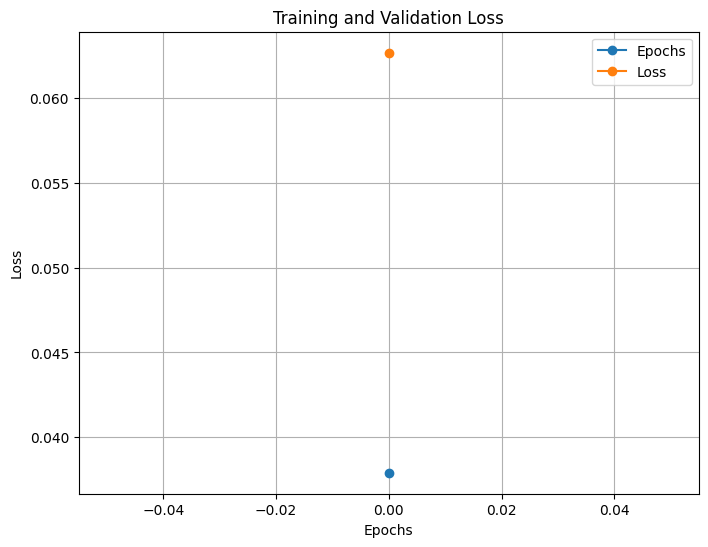

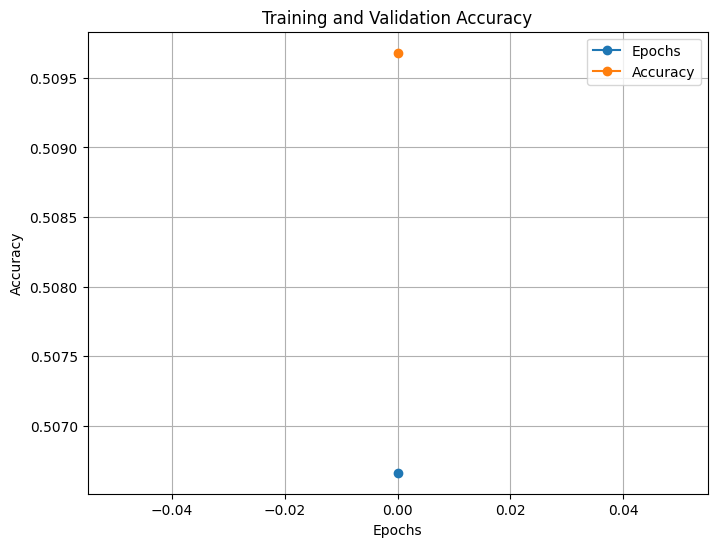

KeyboardInterrupt: 

In [ ]:
# 3 epoci pana acum
parameters = {
    "batch_size" : 6,
    'epochs' : 10,
    'lr_optimizer': 1e-2,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4,
    'patience': 2,
    'early_stopper': 5,
    "momentum" : 0.9,
}

SIZE=(224, 448)

train_transforms = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(size=SIZE, scale=(0.8, 1)),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # A.GaussianBlur(blur_limit=3, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transforms = A.Compose([    
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

data = {
    "train": DataLoader(DepthImageDataset(TRAIN_DATA, transform=train_transforms), batch_size=parameters["batch_size"], shuffle=True, num_workers=2),
    "validation": DataLoader(DepthImageDataset(TEST_DATA, train=False, transform=test_transforms), batch_size=1, shuffle=True, num_workers=2)
}

# print(len(data["train"].dataset))
train_depth_model(data, parameters)

Device-ul folosite este cpu


Using cache found in /home/alf/.cache/torch/hub/pytorch_vision_v0.10.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


tensor(0.4781)


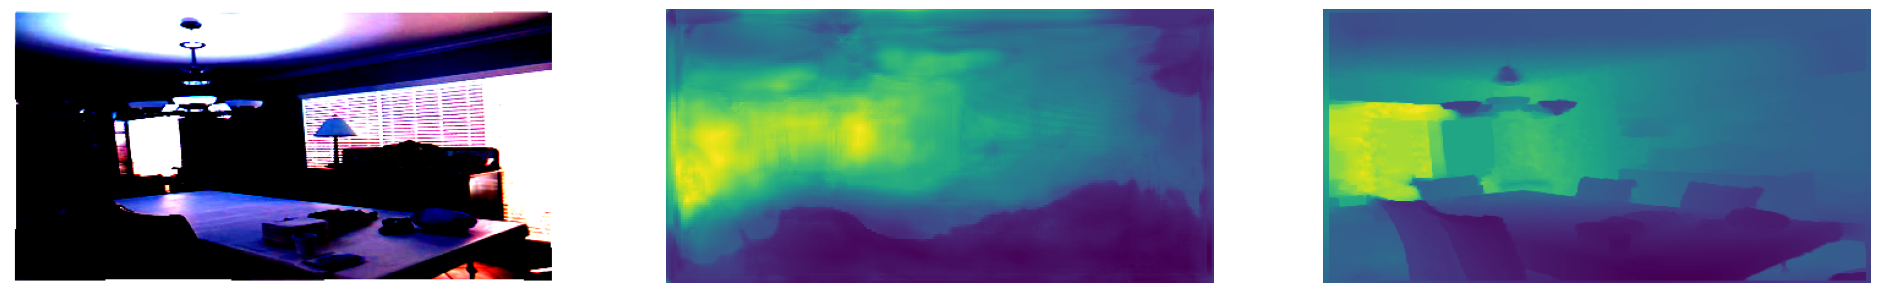

In [13]:
model = get_cpu_model(True)
for iddx, (images, labels) in enumerate(data["validation"]):
    out = model(images)
    print(compute_depth_accuracy_batch_photos(out, labels))
    initial_image = images[0].permute((1, 2, 0))
    labels_image = labels[0].permute((1, 2, 0))
    output_image = out[0].permute((1, 2, 0))
    labels_image = (labels_image.detach().cpu().numpy().squeeze())
    output_image = (output_image.detach().cpu().numpy().squeeze())
    plt.figure(figsize=(24, 24))
    plt.subplot(1, 3, 1) 
    plt.imshow(initial_image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(labels_image)
    plt.axis('off')
    break


In [17]:
torch_input = torch.rand(size=(1, 3, 480, 640))
model_to_convert = FastDepth()
model_to_convert.load_state_dict(torch.load(PATH_MODEL, weights_only=True))
torch.onnx.export(model_to_convert, torch_input, "fast_depth.onnx", opset_version=11)
import onnxruntime
session = onnxruntime.InferenceSession("./fast_depth.onnx")
print("ONNX model loaded successfully in ONNX Runtime")

Using cache found in /home/alf/.cache/torch/hub/pytorch_vision_v0.10.0


ONNX model loaded successfully in ONNX Runtime
